In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os, glob
import cPickle as pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
RESULTS_DIR = '/n/regal/pfister_lab/PERCEPTION/RESULTS/C.Figure1.curvature/'

In [3]:
from keras.models import load_model
from keras import backend as K


Using TensorFlow backend.


In [4]:
import os, sys, time
import cPickle as pickle
sys.path.append('../EXP/')
import ClevelandMcGill as C
from util import Util
reload(C)

<module 'ClevelandMcGill' from '../EXP/ClevelandMcGill/__init__.pyc'>

In [5]:
networks = []

for x in range(4):
    networks.append(load_model(RESULTS_DIR+str(x)+'/XCEPTION/04_noise.h5'))


In [6]:
networks

In [9]:
# generate images
N = 20000
X = [np.zeros((N, 100, 100), dtype=np.float32), \
     np.zeros((N, 100, 100), dtype=np.float32), \
     np.zeros((N, 100, 100), dtype=np.float32), \
     np.zeros((N, 100, 100), dtype=np.float32)]
y = [np.zeros((N), dtype=np.float32), \
     np.zeros((N), dtype=np.float32), \
     np.zeros((N), dtype=np.float32), \
     np.zeros((N), dtype=np.float32)]

for x in range(4):
    FLAGS = [False] * 10 # never more than 10 flags
    for f in range(x):
      FLAGS[f] = True            
    print FLAGS
    
    for n in range(N):

        sparse, image, label, parameters = C.Figure1.curvature(FLAGS)

        image = image.astype(np.float32)
        image += np.random.uniform(0, 0.05,(100,100))
            
        X[x][n] = image
        y[x][n] = label


[False, False, False, False, False, False, False, False, False, False]
[True, False, False, False, False, False, False, False, False, False]
[True, True, False, False, False, False, False, False, False, False]
[True, True, True, False, False, False, False, False, False, False]


In [10]:
# normalize
for i in range(4):
    

    X_min = X[i].min()
    X_max = X[i].max()

    # scale in place
    X[i] -= X_min
    X[i] /= (X_max - X_min)
    X[i] -= .5

    y_min = y[i].min()
    y_max = y[i].max()

    y[i] -= y_min
    y[i] /= (y_max - y_min)

0.0454545


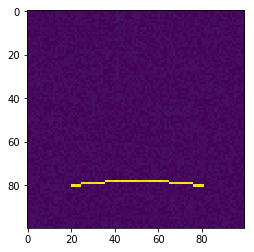

In [11]:
print y[0][10]
imshow(X[0][10]) # just curvature

0.16092


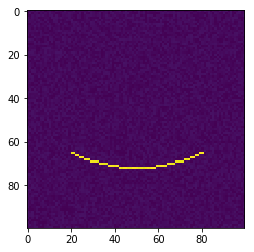

In [12]:
print y[1][10]
imshow(X[1][10]) # curvature + Y

0.0114943


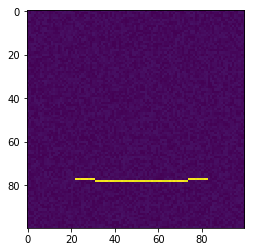

In [13]:
print y[2][10]
imshow(X[2][10]) # curvature + Y + X

0.176623


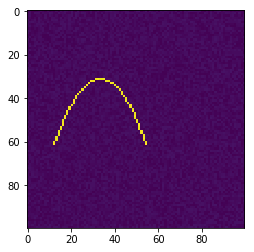

In [14]:
which = 300
print y[3][which]
imshow(X[3][which]) # curvature + Y + X + width

In [17]:
import sklearn.metrics
import keras.applications
results = [[-1]*4]*4

for data in range(4):
    
    network_results = []
    
    for network in range(4):
        
        # make 3d
        X_new = np.stack((X[data],)*3, -1)
        
        feature_generator = keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(100,100,3))
        X_test_3D_features = feature_generator.predict(X_new, verbose=True)
        
        feature_shape = X_test_3D_features.shape[1]*X_test_3D_features.shape[2]*X_test_3D_features.shape[3]
        
        y_pred = networks[network].predict(X_test_3D_features.reshape(len(X_test_3D_features), feature_shape))

#         y_pred = networks[network].predict(X[data].reshape(len(X[data]), 100, 100, 1))
        
        y_test = y[data]
        MLAE = np.log2(sklearn.metrics.mean_absolute_error(y_pred*100, y_test*100)+.125)

        mae = sklearn.metrics.mean_absolute_error(y_pred, y_test)
        
        print 'predicted data', data, 'with network', network, 'MLAE', MLAE, 'MAE', mae
        
        network_results.append(MLAE)
    
    results[data] = network_results

20000/20000 [==============================] - 26s 1ms/step
predicted data 0 with network 0 MLAE 0.703602845492 MAE 0.0150357
20000/20000 [==============================] - 26s 1ms/step
predicted data 0 with network 1 MLAE 1.7254981525 MAE 0.0318194
20000/20000 [==============================] - 26s 1ms/step
predicted data 0 with network 2 MLAE 1.28385930064 MAE 0.0230989
20000/20000 [==============================] - 27s 1ms/step
predicted data 0 with network 3 MLAE 5.45798085681 MAE 0.438308
20000/20000 [==============================] - 27s 1ms/step
predicted data 1 with network 0 MLAE 3.42079022807 MAE 0.105843
20000/20000 [==============================] - 27s 1ms/step
predicted data 1 with network 1 MLAE 0.939396187945 MAE 0.0179273
20000/20000 [==============================] - 27s 1ms/step
predicted data 1 with network 2 MLAE 0.861007370149 MAE 0.0169131
20000/20000 [==============================] - 27s 1ms/step
predicted data 1 with network 3 MLAE 5.11608865814 MAE 0.345564
2

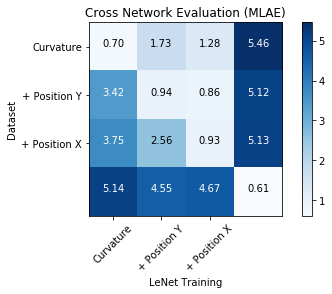

In [18]:
import itertools
def plot_cross_network(cm, classes, title, cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, ['Curvature', '+ Position Y', '+ Position X', '+ Width'], rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Dataset')
    plt.xlabel('LeNet Training')
    plt.savefig('../PAPER/gfx/crossnetwork.pdf', bbox_inches='tight', pad_inches=0)
    
plt.figure()
plot_cross_network(np.array(results), classes=['Curvature', '+ Position Y', '+ Position X'],
                      title='Cross Network Evaluation (MLAE)')

plt.show()


In [119]:
results[:-1]

[[1.4940571924905126, 2.1033311949173972, 1.8651005131917224],
 [4.4135731840416428, 1.4896872723339547, 1.3516542330157073],
 [4.3971879957730202, 4.1659613617830722, 1.2543810536845006]]

Something is wrong with Dataset 3. But that's ok. We can skip it.

In [73]:

y_pred = networks[3].predict(X[0].reshape(len(X[0]), 100, 100, 1))

y_test = y[0]
MLAE = np.log2(sklearn.metrics.mean_absolute_error(y_pred*100, y_test*100)+.125)

mae = sklearn.metrics.mean_absolute_error(y_pred, y_test)

print 'predicted data', data, 'with network', network, 'MLAE', MLAE, 'MAE', mae

predicted data 3 with network 3 MLAE 5.43992369071 MAE 0.43284


In [83]:

X_0_flipped = X[0].copy()
for j in range(X_0_flipped.shape[0]):
    
    X_0_flipped[j] = np.flipud(X_0_flipped[j])

In [94]:


y_pred = networks[3].predict(X_0_flipped.reshape(len(X[0]), 100, 100, 1))

y_test = y[0]
MLAE = np.log2(sklearn.metrics.mean_absolute_error(y_pred*100, y_test*100)+.125)

mae = sklearn.metrics.mean_absolute_error(y_pred, y_test)

print 'predicted data', data, 'with network', network, 'MLAE', MLAE, 'MAE', mae

predicted data 3 with network 3 MLAE 5.46111206704 MAE 0.439263


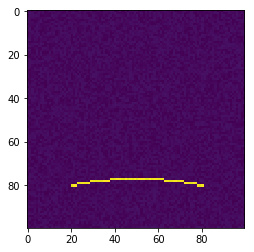

In [93]:
imshow(X[0][0])

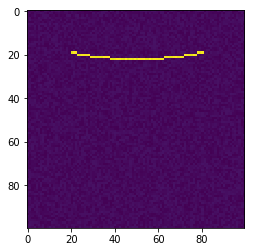

In [86]:
imshow(X_0_flipped[0])

In [95]:
y[0]

array([ 0.08860759,  0.43037975,  0.5316456 , ...,  0.98734176,
        0.89873415,  0.39240506], dtype=float32)

In [97]:
y_pred

array([[ 0.0107424 ],
       [ 0.05599923],
       [ 0.0689    ],
       ..., 
       [ 0.13425328],
       [ 0.10605202],
       [ 0.04554814]], dtype=float32)

In [107]:
10+31/2.

25.5